In [1]:
# encoding: UTF-8
# Copyright Diogenes Ademir Domingos 2017
# Authored by Diogenes Ademir Domingos (k.fus@hotamil.com)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
# Configunrando o notebook.

import random
import numpy as np
import matplotlib.pyplot as plt

# Configunrando o framework Keras.

# Importando a base de dados MNIST (http://yann.lecun.com/exdb/mnist/)
from keras.datasets import mnist

# Importando o modelo do Keras (https://keras.io/getting-started/sequential-model-guide/)
from keras.models import Sequential

# Importando o tipo de camada
from keras.layers import Dense

# Importando modulo de Dropout da rede, para aplicar mutações.
from keras.layers import Dropout

# Importando modulo de achatamento dos vetores.
# Aprimora a entrada. Não afeta o tamanho do lote.
# (https://keras.io/layers/core/#flatten)
from keras.layers import Flatten

# Importanto modulo de convolução (https://keras.io/layers/convolutional/)
from keras.layers.convolutional import Conv2D

# Importando modulo de subamostragem (https://keras.io/layers/pooling/)
from keras.layers.convolutional import MaxPooling2D

# Importando Lib de utilidades (https://keras.io/utils/)
from keras.utils import np_utils

# Importante modulo de trabalho em backend (Th ou Tf) (https://keras.io/backend/)
from keras import backend as K

#import keras_mnist_vis 
#K.set_image_dim_ordering('th')

# permitindo mais de um print por saída
from __future__ import print_function

# Configurando o plot para ser inline ao inves de outra janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load dos dados
# Criando uma matriz numpy de dados de treino.
# Criando uma matriz numpy de dados de teste.
# O conjunto de treinamento possui 60.000 exemplos
# O conjunto de testes de 10.000 exemplos

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Dados de treino shape: ', X_train.shape)
print('Rotulos de treino shape: ', y_train.shape)
print('Dados de teste shape: ', X_test.shape)
print('Rotulos de teste: ', y_test.shape)

Dados de treino shape:  (60000, 28, 28)
Rotulos de treino shape:  (60000,)
Dados de teste shape:  (10000, 28, 28)
Rotulos de teste:  (10000,)


In [5]:
# backup para predição

X_test_orig = X_test
print('Dados de teste backup: ', X_test_orig.shape)

Dados de teste backup:  (10000, 28, 28)


In [6]:
# Amostragem
# Como o conjunto é muito grande para processar na maquina inloco, reduzi criei um subconjunto para experimento.
amostra_treino = 5000
mascara = list(range(amostra_treino))
X_train = X_train[mascara]
y_train = y_train[mascara]

amostra__teste = 500
mask = list(range(amostra__teste))
X_test = X_test[mascara]
y_test = y_test[mascara]

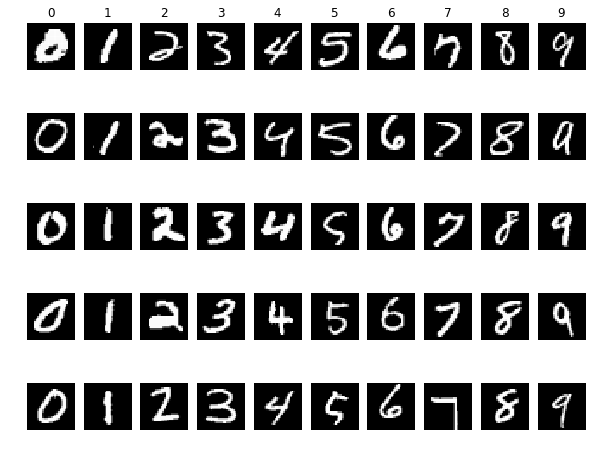

In [7]:
# Visualizando amostra dos dados
# Vetor de classes para indice
classes = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
quantidade_classes = len(classes)
amostras_por_classe = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, amostras_por_classe, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * quantidade_classes + y + 1
        plt.subplot(amostras_por_classe, quantidade_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Configuração do shape da imagem
# Este shape varia de acordo com o framework de backend
# tenshoflow = (quantidade de canais, largura, altura)
# theano = (largura, altura, quantidade de canais)

img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)

print(shape)

(28, 28, 1)


In [9]:
# Alterando os canais de cor para ter apenas um canal
X_train = X_train.reshape((X_train.shape[0],) + shape).astype('float32')
X_test = X_test.reshape((X_test.shape[0],) + shape).astype('float32')

In [10]:
# Binarizando pixels
X_train = X_train / 255
X_test = X_test / 255

In [11]:
# Visualizando dimensão dos dados.
# (Quantidade, largura, altura)
print('Dados de treino shape: ', X_train.shape)
print('Rotulos de treino shape: ', y_train.shape)
print('Dados de teste shape: ', X_test.shape)
print('Rotulos de teste: ', y_test.shape)

Dados de treino shape:  (5000, 28, 28, 1)
Rotulos de treino shape:  (5000,)
Dados de teste shape:  (5000, 28, 28, 1)
Rotulos de teste:  (5000,)


In [12]:
# Definindo a qunatidade de neurõnios por camada da RNA

# quantidade de pixels na camada de entrada de dados
# um neuronio para cada pixel
if K.image_data_format() == 'channels_first':
    num_pixels = X_train.shape[2] * X_train.shape[3]
else:
    num_pixels = X_train.shape[1] * X_train.shape[2]
    
print("Quantidade de neurônios (camada entrada): ",num_pixels)

Quantidade de neurônios (camada entrada):  784


In [13]:
# criando a classificação
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [14]:
# verificando a quantidade de classes encontradas
num_classes = y_test.shape[1]
print('Classes encontradas shape: ',y_test.shape)

Classes encontradas shape:  (5000, 10)


In [15]:
# Criando arquitetura da rede
def deep_cnn_model(num_pixels, num_classes, shape, activation='relu'):
    
    # inicialização de hyperparamentros
	nucleos = 30
	nucleos_dim_1 = 5
	nucleos_dim_2 = 2
	nucleos_dim_2 = 2
	neuronios_camada_densa = 128
    
	model = Sequential() # tipo keras senquencial (https://keras.io/getting-started/sequential-model-guide/)
  
    # [Primeira camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade) para entrada de dados. 
    # Camada ConvNet terá 30 núcleos (campos receptivos de 5 x 5 pixels).
    # Arranjo espacial cmo apenas 1 canal de cor e imagem no tamanho 28x28
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
	model.add(Conv2D(nucleos, (nucleos_dim_1, nucleos_dim_1), padding='same', input_shape=shape, activation= activation))
    
    # [Segunda Camada]
    # Adicionando uma camada de subamostragem (MaxPooling2D).
    # Imagens redimensionadas para 2 × 2 pixels.
	model.add(MaxPooling2D(pool_size=(nucleos_dim_2, nucleos_dim_2)))
    
    #[Terceira Camada]
    # Adicionando uma camada de convolução (Convolution2D - com esparsividade).
    # Camada ConvNet terá 60 núcleos (campos receptivos de 3 x 3 pixels).
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) 
	model.add(Conv2D(nucleos // 2, (nucleos_dim_2, nucleos_dim_2), activation= activation))
    
    #[Quarta Camada]
    # Adicionando uma camada de subamostragem (MaxPooling2D).
    # Imagens redimensionadas para 2 × 2 pixels.
	model.add(MaxPooling2D(pool_size=(nucleos_dim_2, nucleos_dim_2)))
    
    # O dropout atribui, aleatoriamente à entrada de uma fração unidades, valor 0
    # em cada época de treinamento. Ajuda a evitar a overfitting
    # parâmentro (0 > x < 1) é a taxa % de queda
	model.add(Dropout(0.1))
    
    # Achata o vetor
    # Aprimora a entrada. Não afeta o tamanho do lote.
	model.add(Flatten())
    
    #[Quinta Camada]
    # Adicionando camada densa (totalmente conectada) destinada a classificação.
    # Possui 128 neurônios.
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
	model.add(Dense(neuronios_camada_densa, activation= activation))
    
    #[Sexta Camada]
    # Adicionando segunda camada densa (totalmente conectada) destinada a classificação.
    # Possui 64 neuronios
    # Função de ativação do neurônio será Relu (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
	model.add(Dense(neuronios_camada_densa // 2, activation= activation))
    
    #[Sétima Camada]
    # Adicionando uma camada densa (totalmente conectada) para saída de dados, 
    # Função de ativação do neurônio será Softmax (https://en.wikipedia.org/wiki/Softmax_function)
    # tipo da camada de saída é predição
	model.add(Dense(num_classes, activation='softmax', name='preds'))
    
    # Função para otimização estocástica, requer apenas gradientes de primeira ordem com pouco requisito de memória.
    # Referência: (KINGMA, Diederik; BA, Jimmy. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980, 2014.)
    # lr: taxa de aprendizado
    # decay: tamanho do passo da caída do gradiente
	#adam = keras.optimizers.Adam(lr=0.01, decay=1e-6)
        
    # Copilando o modelo
    # Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
    # métrica de reconhecimento será precisão.
    # utilizão adam padrão, sem alterar lr.
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # retorna o modelo compilado
	return model

In [16]:
# instanciando o modelo RNA
model = deep_cnn_model(num_pixels, num_classes, shape)

In [17]:
# Descrevendo a representação do modelo RNA
# Arranjo dimensional: 
# 1 camada de entrada;
# 2 camadas ocultas;
# 1 camada de saída (preds);
# quantidade de parâmentros da rede (pesos).
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 15)        1815      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 540)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               69248     
__________

In [18]:
# Verificando o arranjo espacial do modelo
for i, layer in enumerate(model.layers):
    print ("Camada", i, "\t", layer.name.strip(),"\t\t", layer.input_shape, "\t", layer.output_shape)

Camada 0 	 conv2d_1 		 (None, 28, 28, 1) 	 (None, 28, 28, 30)
Camada 1 	 max_pooling2d_1 		 (None, 28, 28, 30) 	 (None, 14, 14, 30)
Camada 2 	 conv2d_2 		 (None, 14, 14, 30) 	 (None, 13, 13, 15)
Camada 3 	 max_pooling2d_2 		 (None, 13, 13, 15) 	 (None, 6, 6, 15)
Camada 4 	 dropout_1 		 (None, 6, 6, 15) 	 (None, 6, 6, 15)
Camada 5 	 flatten_1 		 (None, 6, 6, 15) 	 (None, 540)
Camada 6 	 dense_1 		 (None, 540) 	 (None, 128)
Camada 7 	 dense_2 		 (None, 128) 	 (None, 64)
Camada 8 	 preds 		 (None, 64) 	 (None, 10)


In [19]:
# Verificando o arranjo espacial do modelo com o pesos
# W.shape = matriz de pesos (quantidade de entradas, quantidade de saídas)
# b.shape = matriz de viés(bias)
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Camada", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)

Camada 0 	 conv2d_1 		 (5, 5, 1, 30) 	 (30,)
Camada 2 	 conv2d_2 		 (2, 2, 30, 15) 	 (15,)
Camada 6 	 dense_1 		 (540, 128) 	 (128,)
Camada 7 	 dense_2 		 (128, 64) 	 (64,)
Camada 8 	 preds 		 (64, 10) 	 (10,)


In [20]:
# Retorna a configuração do modelo RNA
model.get_config()

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 28, 28, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 30,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (5, 5),
   'name': 'conv2d_1',
   'padding': 'same',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'data_format': 'channels_last',
   'name': 'max_pooling2d_1',
   'padding': 'valid',
   'pool_size': (2, 2),
   'strides': (2, 2),
   'trainable': True}},
 {'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_re

In [20]:
# Verificando os pesos da RNA
model.get_weights()

[array([[[[  3.68233398e-02,   5.87492287e-02,  -7.75522217e-02,
             6.90500587e-02,  -6.81096911e-02,   4.18338180e-02,
             3.37526575e-02,  -2.35735476e-02,  -2.51490399e-02,
             1.58761144e-02,   7.73245096e-02,  -2.01735944e-02,
             6.11273199e-02,   8.17168057e-02,  -1.11299008e-02,
            -6.70808256e-02,  -2.29169726e-02,  -4.44718264e-02,
             4.60702926e-03,  -2.65853629e-02,   8.11934024e-02,
             3.58363837e-02,   6.05133772e-02,   1.72200948e-02,
            -3.80287170e-02,   2.53319740e-07,  -3.81483138e-02,
             5.96283525e-02,   3.98179293e-02,  -6.12220168e-02]],
 
         [[  1.99362710e-02,  -4.30491380e-02,  -1.53989270e-02,
             7.56032765e-02,  -3.69115919e-02,  -2.66769342e-02,
             2.87271589e-02,  -8.24084878e-02,  -8.07980895e-02,
             4.62232530e-03,  -1.38049126e-02,  -2.01571286e-02,
            -8.05968046e-03,  -6.75700605e-04,   1.19783953e-02,
             8.443707

In [21]:
# Treinando o modelo RNA para 01 época
# Função FIT: realiza o treinamento até uma quantidade de épocas determinada.
# parametro validation_data: Dados para avaliar a perda do gradiente ao final de cada época
# parametro batch_size: numero de amostras para atualizar a perda do gradientes
# Paramentro verbose : 0 = silent, 1 = verbose, 2 = one log line per epoch.
# %time = medindo tempo do treino
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=200, verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/1
5000/5000 [==============================] - 12s - loss: 1.7545 - acc: 0.5094 - val_loss: 1.0045 - val_acc: 0.6970
Wall time: 13.1 s


In [22]:
# Avaliando o modelo RNA
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=0)
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
Erro de: 30.30%
Precisão de: 69.70%


In [23]:
# Treinando o modelo RNA para 05 épocas
# %time = medindo tempo do treino
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=200, verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 10s - loss: 0.6269 - acc: 0.8008 - val_loss: 0.5476 - val_acc: 0.8400
Epoch 2/5
5000/5000 [==============================] - 10s - loss: 0.3941 - acc: 0.8776 - val_loss: 0.3857 - val_acc: 0.8876
Epoch 3/5
5000/5000 [==============================] - 10s - loss: 0.2901 - acc: 0.9112 - val_loss: 0.2994 - val_acc: 0.9098
Epoch 4/5
5000/5000 [==============================] - 10s - loss: 0.2249 - acc: 0.9310 - val_loss: 0.2558 - val_acc: 0.9204
Epoch 5/5
5000/5000 [==============================] - 9s - loss: 0.1885 - acc: 0.9454 - val_loss: 0.2312 - val_acc: 0.9276
Wall time: 52.3 s


In [25]:
# Avaliando o modelo RNA
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=1)
print()
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
4960/5000 [============================>.] - ETA: 0s
Erro de: 7.24%
Precisão de: 92.76%


In [26]:
# Treinando o modelo RNA para 100 épocas
# %time = medindo tempo do treino
%time history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/20
5000/5000 [==============================] - 10s - loss: 0.1644 - acc: 0.9518 - val_loss: 0.2156 - val_acc: 0.9356
Epoch 2/20
5000/5000 [==============================] - 11s - loss: 0.1405 - acc: 0.9594 - val_loss: 0.1800 - val_acc: 0.9398
Epoch 3/20
5000/5000 [==============================] - 9s - loss: 0.1233 - acc: 0.9616 - val_loss: 0.1827 - val_acc: 0.9404
Epoch 4/20
5000/5000 [==============================] - 8s - loss: 0.1074 - acc: 0.9686 - val_loss: 0.1451 - val_acc: 0.9526
Epoch 5/20
5000/5000 [==============================] - 10s - loss: 0.0923 - acc: 0.9732 - val_loss: 0.1457 - val_acc: 0.9496
Epoch 6/20
5000/5000 [==============================] - 10s - loss: 0.0850 - acc: 0.9738 - val_loss: 0.1418 - val_acc: 0.9540
Epoch 7/20
5000/5000 [==============================] - 8s - loss: 0.0802 - acc: 0.9762 - val_loss: 0.1247 - val_acc: 0.9576
Epoch 8/20
5000/5000 [==============================] - 11s - loss: 0.069

In [27]:
# Avaliando o modelo RNA
print('Metricas do Modelo: {}'.format(model.metrics_names))
metricas = model.evaluate(X_test, y_test, verbose=1)
print()
print("Erro de: %.2f%%" % (100-metricas[1]*100))
print("Precisão de: %.2f%%" % (metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
4992/5000 [============================>.] - ETA: 0s
Erro de: 3.34%
Precisão de: 96.66%


In [28]:
# Historico do treino
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


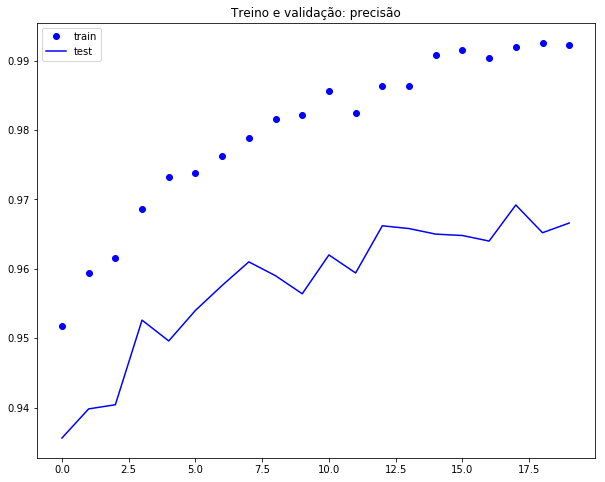

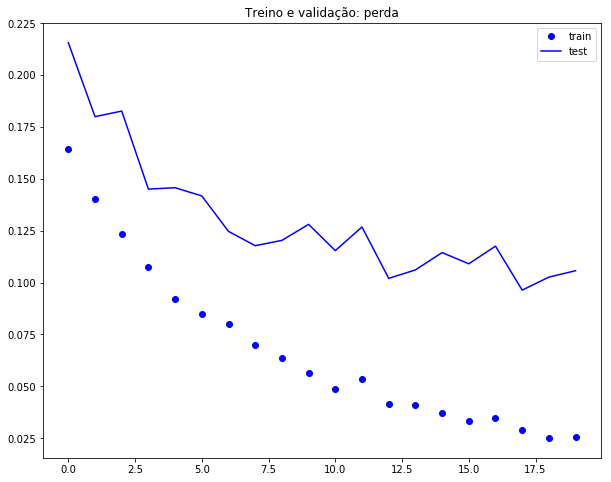

In [112]:
# Historio de precição
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Treino e validação: precisão')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Treino e validação: perda')

plt.show()

In [31]:
# utilizando o modelo para predição.
predicted = model.predict(X_test,batch_size=32, verbose=1).argmax(-1)
print('\nQuantidade de imagens analisadas: ', predicted.shape)

4960/5000 [============================>.] - ETA: 0s
Quantidade de imagens analisadas:  (5000,)


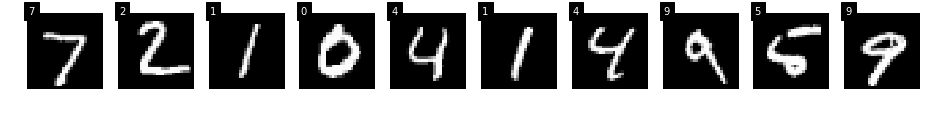

In [32]:
# Visualizando e comparando a predição com a base original.
amosta = 10
plt.figure(figsize=(16,8))
for i in range(amosta):
    plt.subplot(1, amosta, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='white', 
             bbox=dict(facecolor='black', alpha=1))
    plt.axis('off')

In [92]:
# Matriz de confusão da predição
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

print(predicted.shape)
print(y_test.shape)

print(confusion_matrix(np.argmax(y_test,axis=1), predicted))



(5000,)
(5000, 10)
[[457   0   1   0   0   0   2   0   0   0]
 [  0 564   1   1   0   2   0   0   2   1]
 [  4   1 502   8   3   0   2   5   5   0]
 [  1   0   2 484   0   9   0   3   0   1]
 [  0   0   0   0 494   0   2   0   1   3]
 [  1   1   0   2   0 450   0   2   0   0]
 [  8   3   0   0   3   4 442   0   2   0]
 [  0   2   6   2   0   0   0 488   3  11]
 [  8   0   0  11   3   2   1   4 455   5]
 [  2   3   0   3  10   2   0   2   1 497]]


In [96]:
# Precision 
print(classification_report(y_test, predicted, target_names=classes))

ValueError: Mix type of y not allowed, got types {'multilabel-indicator', 'multiclass'}

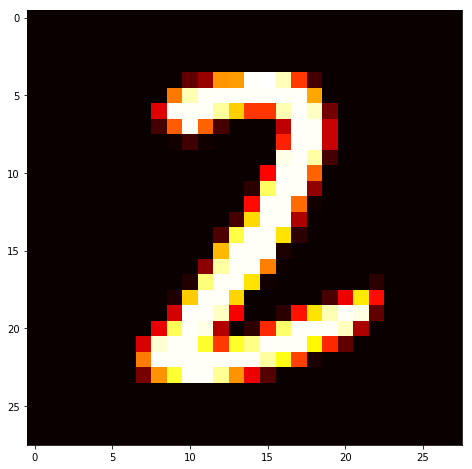

In [128]:
from keras.preprocessing import image
from keras.utils.data_utils import get_file
import time
import os

#IMAGE_FOLDER = "%USERPROFILE%/.keras/datasets/mnist.npz"
path = get_file('mnist.npz', origin='%USERPROFILE%/.keras/datasets/mnist.npz')
f = np.load(path)
i = np.random.randint(X_test.shape[0])
input_img_data = f['x_test'][i]
f.close()
plt.imshow(input_img_data, cmap="hot")

In [129]:
input_img_data = np.expand_dims(input_img_data, axis=0)
print('Input image shape:', input_img_data.shape)

Input image shape: (1, 28, 28)


In [130]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 15)        1815      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 540)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               69248     
__________

In [131]:
# Listando as camadas da rede
from collections import OrderedDict
layer_dict = OrderedDict()
for layer in model.layers[0:]:
    layer_dict[layer.name] = layer
    print(layer.name)

conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
dropout_1
flatten_1
dense_1
dense_2
preds


In [132]:
# Buscando as ativações da camada de convolucao

def get_activations(model, layer, input_img_data):
    activations_f = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
    activations = activations_f((input_img_data, False))
    return activations

In [133]:
# Verificando o shape

img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)

print(shape)
print(input_img_data.shape)
input_img_data = input_img_data.reshape((input_img_data.shape[0],) + shape).astype('float32')
print(input_img_data.shape)

(28, 28, 1)
(1, 28, 28)
(1, 28, 28, 1)


In [134]:
# Pegando as ativações
layer_name = 'conv2d_1'
layer = layer_dict[layer_name]
activations = get_activations(model, layer, input_img_data)

In [135]:
# Visualizando o shape da primeira ativação
print(len(activations))
activation = activations[0]
activation.shape

1


(1, 28, 28, 30)

In [136]:
# Quantidade de núcleos
print('Quantidade de finltros na camada: ',layer.filters)

Quantidade de finltros na camada:  30


Quantidade de ativações na imagem:  28


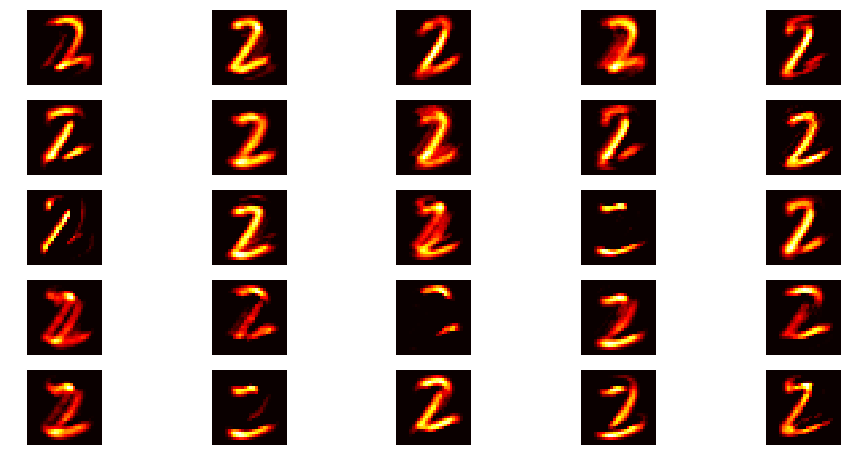

In [137]:
# Visualizando imagem através das camadas

activated_img = activation[0]
print("Quantidade de ativações na imagem: ",len(activated_img))
ativacoes_amostra = 5
fig = plt.figure(figsize=(16, 8))
for i in range(ativacoes_amostra):
    for j in range(ativacoes_amostra):
        idx = (ativacoes_amostra*i)+j
        ax = fig.add_subplot(ativacoes_amostra, ativacoes_amostra, idx+1)
        ax.imshow(activated_img[:,:,idx], cmap="hot")
        plt.axis('off')

In [138]:
# Verificando a imagem convoluida pela média
conv_img_mean = np.mean(activated_img, axis=2)

In [139]:
# confere o tamnaho do shape
conv_img_mean.shape

(28, 28)

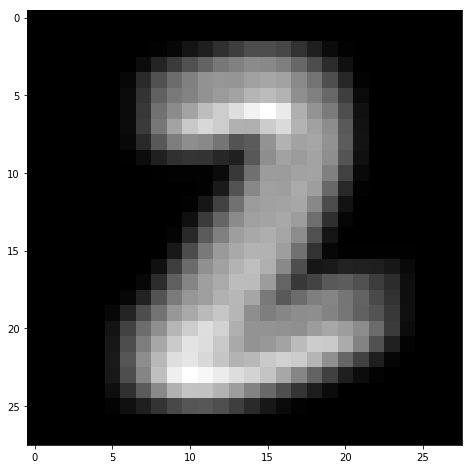

In [141]:
# Mostrar a imagem pela média
plt.imshow(conv_img_mean)

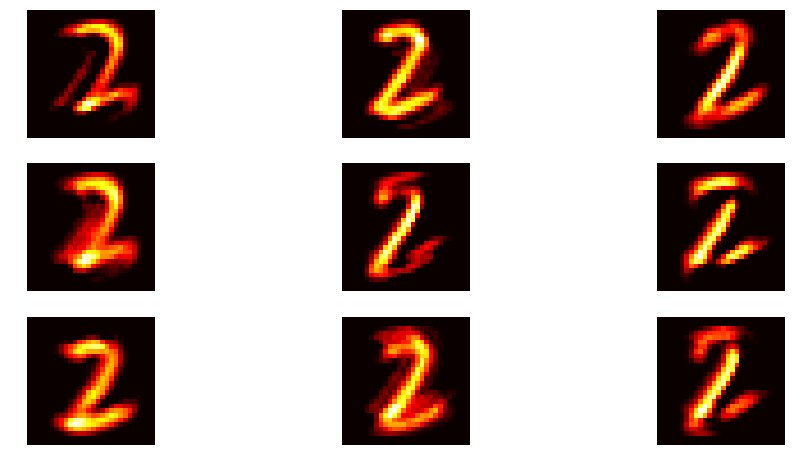

In [142]:
# Visualizando os nucleos da camanda de convolução

layer_name = 'conv2d_1'
layer = layer_dict[layer_name]
activations = get_activations(model, layer, input_img_data)

activated_img = activations[0][0] 
n = 3
fig = plt.figure(figsize=(16, 8))
for i in range(n):
    for j in range(n):
        idx = (n*i)+j
        ax = fig.add_subplot(n, n, idx+1)
        ax.imshow(activated_img[:,:,idx], cmap="hot")
        plt.axis('off')

In [143]:
# escolhendo um filtro para visualizar o nucleo
filter_index = 1

In [144]:
#layer_output = layer_dict[layer_name].output
#loss = K.mean(layer_output[:, :, :, filter_index])

In [145]:
# compute the gradient of the input picture wrt this loss
#grads = K.gradients(loss, input_img_data)[0]

In [160]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [165]:
# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, 28, 28)) * 20 + 128.

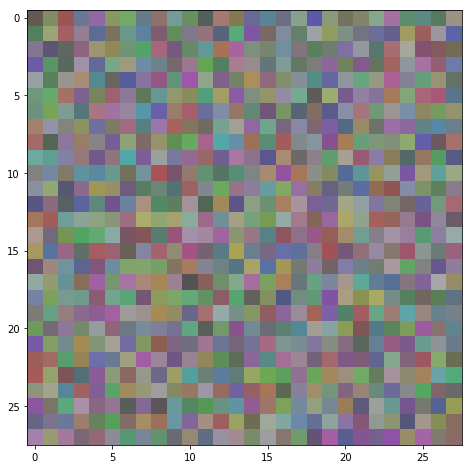

In [167]:

img = input_img_data[0]
img = deprocess_image(img)
# Mostrar a imagem pela média
plt.imshow(img, cmap="hot")
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)